# Assignment 3


## Overview

Following the previous assignments, we will continue working on the [LinkSO](https://dl.acm.org/doi/pdf/10.1145/3283812.3283815) dataset in this assignment. Notice this assignment is the same as

Specifically, we will learn a ranker that could automatically rank the most relevant tags before others for a given question. This ranker will be based on one of the most frequently used pretrained language models (PLM) - BERT.

Upon the completion of this assignment, you will

- Get hands-on experiences with PLMs through `transformers` library.
- Develop a functional ranking system that is capable of find most relevant tags given the StackOverflow question description.

Notice that
- If you are not familiar with programming with `torch` and `transformers`, you could develop your solution based on the post [here](https://towardsdatascience.com/transformers-for-multilabel-classification-71a1a0daf5e1).
- You should run each and every cell even though some of them do not print any messages.


## Configuring Environment
The runtime could be significantly improved (it is not unusual to have a 50x speedup) when we set the computation environment to GPU. To do this,

- Step 1: Go to Runtime $\rightarrow$ Change runtime type.
- Step 2: In the drop-down list of Hardware accelerator, choose GPU.


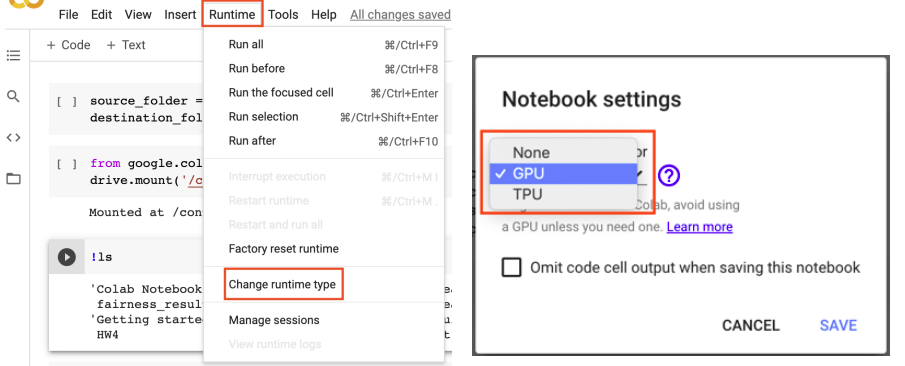

If you follow the steps in the cell above, you will observe something similar after running the cell below. The message shows that your code could now be accelerated with a Tesla K80 GPU; this GPU has 11441MB graphic memory, which is sufficient for our application.

```bash
Tue Nov 16 21:57:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+
```

On the other hand, a failed setup may look like the following
```bash
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.
```

In [1]:
! nvidia-smi

Fri Nov 15 02:07:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Downloading Data



In [2]:
! rm -rf cs589assignment3/
! git clone https://github.com/guanqun-yang/cs589assignment4.git cs589assignment3

Cloning into 'cs589assignment3'...
remote: Enumerating objects: 18, done.
remote: Total 18 (delta 0), reused 0 (delta 0), pack-reused 18 (from 1)
Receiving objects: 100% (18/18), 1.61 MiB | 2.63 MiB/s, done.
Resolving deltas: 100% (2/2), done.


## Installing and Importing Libraries

In [3]:
! pip -q install transformers datasets
! pip -q install seedir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.0/113.0 kB 3.7 MB/s eta 0:00:00


In [4]:
import os
import json
import math
import torch
import pickle
import string
import pathlib
import itertools

import numpy as np
import seedir as sd
import pandas as pd

from termcolor import cprint
from scipy.special import (
    expit,
    softmax
)
from collections import (
    defaultdict,
    Counter
)

from torch.nn import BCEWithLogitsLoss
from torch.utils.data import (
    DataLoader,
    TensorDataset,
    RandomSampler,
    SequentialSampler
)

from tqdm.autonotebook import tqdm, trange
from sklearn.preprocessing import MultiLabelBinarizer

from datasets import (
    Dataset,
    load_dataset
)
from transformers import (
    AdamW,
    BertTokenizer,
    BertForSequenceClassification,
)

<ipython-input-4-a990d51c3e24>:32: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Helper Functions

In [5]:
def prepare_dataloader(encodings, labels, ids, batch_size=32):
    lst2arr = lambda lst: np.array(lst)[np.newaxis, :]

    input_ids, token_type_ids, attention_masks = [torch.tensor(np.hstack(lst2arr(v))) for v in encodings.values()]
    labels = torch.tensor(labels)
    ids = torch.tensor(ids)

    dataset = TensorDataset(input_ids, attention_masks, labels, token_type_ids, ids)
    sampler = RandomSampler(dataset)

    dataloader = DataLoader(dataset, sampler=sampler, batch_size=batch_size)

    return dataloader


def evaluate_model(model, dataloader, verbose=False):
    model.eval()
    logits, trues, ids = list(), list(), list()
    with tqdm(total=len(dataloader), desc="Prediction" if verbose else None) as pbar:
        for batch in dataloader:
            batch_input_ids, batch_attention_masks, batch_labels, batch_token_type_ids, batch_ids = \
            [t.to(device) for t in batch]

            with torch.no_grad():
                output = model(batch_input_ids, token_type_ids=None, attention_mask=batch_attention_masks)

                logits.extend(output.logits.detach().cpu().numpy())
                trues.extend(batch_labels.cpu().numpy())
                ids.extend(batch_ids.cpu().numpy().tolist())

                pbar.update(1)

    trues = [t == 1 for t in trues]

    return trues, logits, ids


def ndcg(ranking, topK=None):
    # when topK is None, the entire list is chosen
    # make sure the ranking contains numeric or boolean relevance
    assert all(rel * 0 == 0 for rel in ranking),\
    "make sure input array has only numeric or boolean types"

    # compute dcg
    dcg = 0
    for idx, rel in enumerate(ranking[:topK]):
        rank = idx + 1
        dcg += (2 ** rel - 1) / np.log2(rank + 1)

    # compute idcg
    idcg, max_rel = 0, max(ranking)
    rel_cnt = sum([math.isclose(rel, 0) == False for rel in ranking])
    for idx in range(min(rel_cnt, topK) if topK else rel_cnt):
        rank = idx + 1
        idcg += (2 ** max_rel - 1) / np.log2(rank + 1)

    score = dcg / idcg
    return score


def preprocess_text(text):
    return " ".join([token.lower().strip(string.punctuation) for token in text.split()])

## Data

Before we dive into development, it is often a good idea to see how the data is organized and what they look like.

After executing the cell below, we could find that:

- Each row is identified by an integer called `name`.
- The `tags` field for the `test.json` are all `NaN`.
- The number of unique tags is 50. Your system will rank these tags based on their relatedness to the question.


In [6]:
cprint("directory structure:", "red")
sd.seedir("cs589assignment3", style='lines', itemlimit=10, depthlimit=2, exclude_folders=".git")

directory structure:
cs589assignment3/
└─python/
  ├─val.json
  ├─train.json
  └─test.json


In [7]:
df_dict = dict()
pd.options.display.max_columns = 5
for split in ["train", "val", "test"]:
    cprint(f"a sample of {split} split:", "red")
    df = pd.read_json(f"cs589assignment3/python/{split}.json", lines=True, orient="records")
    print(df.sample(n=5))

    df_dict[split] = df

a sample of train split:
                                               question                 tags  \
1173  problem easy want iterate element list next on...               [list]   
3319  related rather follow want subplots sharing on...         [matplotlib]   
2004  python im trying perform value counts pandas c...             [pandas]   
2455  collection d points points sampled constant le...  [numpy, matplotlib]   
1325  trying make scraper pull links titles prices b...             [scrapy]   

      name  
1173  1173  
3319  3319  
2004  2004  
2455  2455  
1325  1325  
a sample of val split:
                                              question                   tags  \
206  nb question similar exactly answer question su...               [pandas]   
421  trying install beautifulsoup new notebook win ...         [windows, pip]   
239  new python would like install use ocr library ...           [python-2.7]   
436  want write following lxml etree subelements od...              [

In [8]:
cprint("unique tags:", "red")
tags = list(itertools.chain(*df_dict["train"].tags.tolist()))
print(pd.DataFrame({"tag": tag, "count": Counter(tags)[tag]} for tag in set(tags)))

unique tags:
                       tag  count
0                 datetime     89
1                   arrays    109
2               python-2.7    364
3                  windows    124
4                    scipy    184
5                      osx     89
6                     nltk     57
7               matplotlib    423
8                   string    129
9               tensorflow     56
10                    pyqt     48
11         multiprocessing     67
12               dataframe    110
13                 parsing     52
14              python-3.x    347
15             performance     77
16                selenium     69
17              dictionary    159
18          multithreading     71
19              virtualenv     69
20                   regex    110
21            scikit-learn     56
22                     c++     43
23                 tkinter    147
24                  opencv     46
25                 unicode     59
26                   mysql     62
27  python-imaging-library     72
2

## Hyperparameters

In [9]:
n_label = 50
lang = "python"
n_epoch = 5
learning_rate = 5e-6
batch_size = 4
dataset_size = 100

## Loading and Preprocessing the Data







In [10]:
data_path = pathlib.Path(f"cs589assignment3/{lang}")

data_files = {
    "train": str(data_path / "train.json"),
    "validation": str(data_path / "val.json"),
    "test": str(data_path / "test.json")
}

dataset = load_dataset("json", data_files=data_files)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

At first, you may want to work with smaller sample of dataset. Uncomment the cell below to sample `dataset_size` samples from training, validation, and test set for experiment. The `dataset_size` defaults to 100 and could be optionally set to other positive integer. But you may not want to set `dataset_size` too small as we would like all 50 unique tags appear in the training split.

In [11]:
#################################### UNCOMMENT TO SAMPLE DATASET ####################################

# train_df = pd.DataFrame(dataset["train"])
# unique_tags = set(itertools.chain(*train_df.tags.tolist()))

# n_sample = int(dataset_size / len(unique_tags))
# train_dfs = [train_df[train_df.tags.apply(lambda x: tag in x)].sample(n=n_sample) \
#              for tag in unique_tags]

# dataset["train"] = Dataset.from_pandas(pd.concat(train_dfs, ignore_index=True))

# for split in ["validation", "test"]:
#     dataset[split] = dataset[split].select(np.arange(dataset_size))

####################################################################################################

In [12]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['question', 'tags', 'name'],
        num_rows: 4678
    })
    validation: Dataset({
        features: ['question', 'tags', 'name'],
        num_rows: 585
    })
    test: Dataset({
        features: ['question', 'tags', 'name'],
        num_rows: 585
    })
})


In [13]:
tokenization_option_dict = {"max_length": 32, "padding": "max_length", "truncation": True}

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(dataset["train"]["question"], **tokenization_option_dict)
val_encodings = tokenizer(dataset["validation"]["question"], **tokenization_option_dict)
test_encodings = tokenizer(dataset["test"]["question"], **tokenization_option_dict)

encoder = MultiLabelBinarizer()
train_labels = encoder.fit_transform(dataset["train"]["tags"])
val_labels = encoder.transform(dataset["validation"]["tags"])
test_labels = np.zeros((dataset["test"].num_rows, n_label))

train_ids = dataset["train"]["name"]
val_ids = dataset["validation"]["name"]
test_ids = dataset["test"]["name"]

train_dataloader = prepare_dataloader(train_encodings, train_labels, train_ids, batch_size=batch_size)
val_dataloader = prepare_dataloader(val_encodings, val_labels, val_ids, batch_size=batch_size)
test_dataloader = prepare_dataloader(test_encodings, test_labels, test_ids, batch_size=batch_size)

# map index to tag
index2tag_dict = {idx: tag for idx, tag in enumerate(encoder.classes_)}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Loading the Pretrained Language Model (PLM)

In [14]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=n_label).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Preparing for Training



In [15]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


criterion = BCEWithLogitsLoss()
optimizer = AdamW(optimizer_grouped_parameters,
                  lr=learning_rate,
                  correct_bias=True)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Training Loop

When you try to compelete the cell below, you may want to look at the documentation
- Model: [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#transformers.BertForSequenceClassification)
- Loss function: [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)
- Optimizer: [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html?highlight=adamw#transformers.AdamW)


In [16]:
for epoch in trange(n_epoch, desc="Epoch"):
    model.train()

    train_loss, train_step, train_sample = 0, 0, 0
    with tqdm(total=len(train_dataloader), desc=f"Epoch={epoch+1}, Training Steps") as pbar:
        for batch in train_dataloader:
            batch_input_ids, batch_attention_masks, batch_labels, batch_token_type_ids, _ = \
            [t.to(device) for t in batch]
    ###################################### START OF IMPLEMENTATION ######################################
            outputs = model(batch_input_ids, token_type_ids=batch_token_type_ids,
                            attention_mask=batch_attention_masks)
            logits = outputs.logits
            loss = criterion(logits.view(-1,n_label),batch_labels.type_as(logits).view(-1,n_label))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    ####################################### END OF IMPLEMENTATION #######################################
            train_step += 1
            train_sample += batch_input_ids.size(0)
            train_loss += loss.item()

            pbar.update(1)

    cprint("\nTrain loss: {:.6f}".format(train_loss / train_step), "red")

    trues, logits, _ = evaluate_model(model, val_dataloader)

    ndcg_list = list()
    for true, logit in zip(trues, logits):
        logit[true == 0] = 0
        rel_dict = {index2tag_dict[idx]: logit[idx] for idx in np.flatnonzero(logit)}
        ranking = [rel_dict[tag] for tag in encoder.inverse_transform(true[np.newaxis, :])[0]]

        # convert raw logits to probability
        ranking = expit(ranking)

        ndcg_list.append(ndcg(ranking))

    cprint("\nValidation nDCG: {:.6f}".format(sum(ndcg_list) / len(ndcg_list)), "red")

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch=1, Training Steps:   0%|          | 0/1170 [00:00<?, ?it/s]


Train loss: 0.227123


  0%|          | 0/147 [00:00<?, ?it/s]


Validation nDCG: 0.940999


Epoch=2, Training Steps:   0%|          | 0/1170 [00:00<?, ?it/s]


Train loss: 0.117557


  0%|          | 0/147 [00:00<?, ?it/s]


Validation nDCG: 0.925614


Epoch=3, Training Steps:   0%|          | 0/1170 [00:00<?, ?it/s]


Train loss: 0.112703


  0%|          | 0/147 [00:00<?, ?it/s]


Validation nDCG: 0.915762


Epoch=4, Training Steps:   0%|          | 0/1170 [00:00<?, ?it/s]


Train loss: 0.106213


  0%|          | 0/147 [00:00<?, ?it/s]


Validation nDCG: 0.909543


Epoch=5, Training Steps:   0%|          | 0/1170 [00:00<?, ?it/s]


Train loss: 0.098113


  0%|          | 0/147 [00:00<?, ?it/s]


Validation nDCG: 0.904532


## Testing Your System with an Actual Post

Before we obtain predictions for `test.json`, it might be interesting to see how our system works for a post in the wild. The post in the following cell is taken from [here](https://stackoverflow.com/q/16476924/7784797). In the original post, the tag `pandas` is ranked before `dataframe`. Let's see if our system could rank `pandas` and `dataframe` correctly.


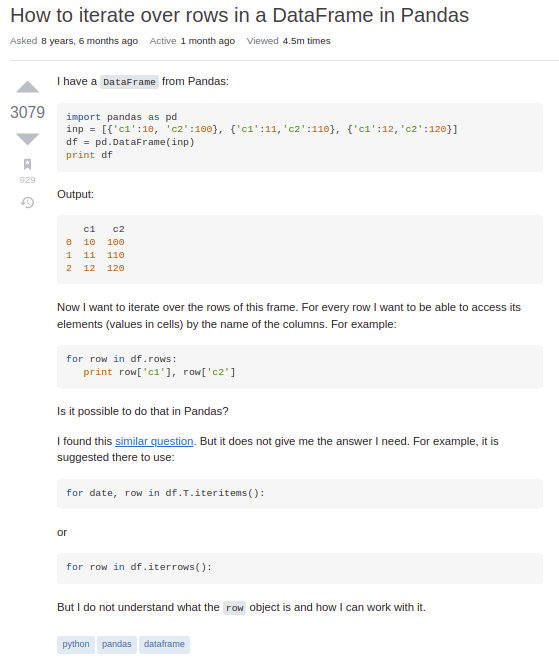

In [17]:
text = """
I have a DataFrame from Pandas:

import pandas as pd
inp = [{'c1':10, 'c2':100}, {'c1':11,'c2':110}, {'c1':12,'c2':120}]
df = pd.DataFrame(inp)
print df
Output:

   c1   c2
0  10  100
1  11  110
2  12  120
Now I want to iterate over the rows of this frame. For every row I want to be able to access its elements (values in cells) by the name of the columns. For example:

for row in df.rows:
   print row['c1'], row['c2']
Is it possible to do that in Pandas?

I found this similar question. But it does not give me the answer I need. For example, it is suggested there to use:

for date, row in df.T.iteritems():
or

for row in df.iterrows():
But I do not understand what the row object is and how I can work with it.
"""

processed_text = preprocess_text(text)
tokenized_text = tokenizer(processed_text)

output = model(torch.tensor(tokenized_text["input_ids"]).unsqueeze(0).to(device),
               attention_mask=torch.tensor(tokenized_text["attention_mask"]).unsqueeze(0).to(device))

tags = [index2tag_dict[idx] for idx in np.argsort(output.logits.detach().cpu().numpy().ravel())[::-1]]
for tag in ["pandas", "dataframe"]:
    print("{}'s rank: {}".format(tag, tags.index(tag) + 1))


pandas's rank: 1
dataframe's rank: 4


## Saving the Test Results for Submission

Replace the `CWID` variable with your CWID and run the cells below.

In [18]:
CWID = "20034068"

In [19]:
_, logits, ids = evaluate_model(model, test_dataloader)
records = list()
for name, logit in zip(ids, logits):
    records.append(
        {
            "name": name,
            **{index2tag_dict[idx]: v for idx, v in enumerate(logit)}
        }
    )

result_df = pd.DataFrame(records)
result_df.to_json(f"{CWID}.json", lines=True, orient="records")

  0%|          | 0/147 [00:00<?, ?it/s]